# Facultad de Ciencias, UNAM.
# Proyecto Redes Neuronales:

## Clasificador de géneros musicales

### Integrantes:
- Jorge Francisco Cortés López - 314330981
- Sandra del Mar Soto Corderi - 3157070267

## Introducción y motivación.
Uno de los retos más interesantes para la inteligencia artificial es el de intentar que clasifiquemos o generemos arte usando diferentes herramientas como las redes neuronales, ya que hasta la fecha no existe un algoritmo o clasificador en el que pasemos una canción o ciertos atributos de una canción y nos diga a qué género pertenece.

Para éste proyecto intentamos ver hasta donde podemos llegar a clasificar el conjunto de canciones que obtuvimos con ciertas características musicales como: tono, tiempo, tempo, popularidad, entre otros.

Se utilizó una red multicapa, ya que queríamos ver hasta donde podíamos explotar sus capacidades, existen otras arquitecturas más modernas como las redes convolucionales, sin embargo era mucho más complejo y difícil obtener los datos, por lo que decidimos optar por una arquitectura más sencilla y ver hasta donde nos podía llevar. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Si se tiene GPU Nvidia se puede descomentar.
#device = "cuda"
device = "cpu"

# Procesamiento de datos
Lo primero que hacemos es cargar los datos con ayuda de la biblioteca pandas, que es de mucha utilidad para cargar y manipular datos en python. Mostramos un sample de los datos.

In [5]:
music_data = 'data/musicdata.csv'
music_data = pd.read_csv(music_data)
music_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


## Limpieza de datos
Vemos si existen canciones duplicadas en diferentes géneros, en éste caso hay canciones que están en varios géneros, por lo que lo mejor será quitarlas.

Además de ésto, quitamos algunos géneros que no cuentan con muchas canciones o que consideramos que pudieran afectar al desempeño de la red ya que por ejemplo Children's Music no lo consideramos un género como tal.

In [6]:
# Duplicados
music_data = music_data.drop_duplicates(subset=['track_name'], keep='first', ignore_index=True)

# Géneros que consideramos para quitar 
# (Muchas canciones de Hip Hop se pueden categorizar como Rap)
music_data.drop(music_data[music_data.genre == 'Rap'].index, inplace=True)
music_data.drop(music_data[music_data.genre == 'Children\'s Music'].index, inplace=True)
music_data.drop(music_data[music_data.genre == 'Children’s Music'].index, inplace=True)
music_data.drop(music_data[music_data.genre == 'A Capella'].index, inplace=True)
music_data.drop(music_data[music_data.genre == 'Indie'].index, inplace=True)

Quitamos también las características que no nos interesan, en éste caso: 

* artist_name
* track_name
* track_id
* duration_ms

no nos interesan, ya que ésto en un principio no tendría porqué influenciar el género de una canción.

In [7]:
unused_col = ['artist_name', 'track_name', 'track_id', 'duration_ms']
music_data = music_data.drop(columns=unused_col)

Finalmente, vemos si hay ejemplares que tengan algún dato faltante.

In [8]:
music_data.isna().sum().sum()

0

## Codificación y normalización
Una vez que nuestros datos están limpios podemos hacer la codificación para nuestra red neuronal, vamos que hay algunos que necesitan ser normalizados como popularity, loudness y tempo. Sin embargo también vemos que key, mode y time signature necesitan ser codificados.

In [9]:
# Normalizamos las columnas correspondientes.
mms = MinMaxScaler()
music_data[['popularity','loudness','tempo']] = \
            mms.fit_transform(music_data[['popularity','loudness','tempo']])

In [10]:
# Codificamos a One hot encoding las columnas necesarias.
music_data = \
    pd.get_dummies(data=music_data, columns=['key', 'mode', 'time_signature'], dtype=float)

Luego de codificar y normalizar los ejemplares, aplicamos codificamos igualmente las clases con ayuda de la clase LabelEncoder.

In [11]:
le = LabelEncoder()
music_data['genre'] = le.fit_transform(music_data.genre.values).astype(float)

Finalmente vemos cómo quedaron las columnas de los datos ya procesados y limpios para proseguir con los demás pasos

In [12]:
music_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139919 entries, 0 to 148614
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   genre               139919 non-null  float64
 1   popularity          139919 non-null  float64
 2   acousticness        139919 non-null  float64
 3   danceability        139919 non-null  float64
 4   energy              139919 non-null  float64
 5   instrumentalness    139919 non-null  float64
 6   liveness            139919 non-null  float64
 7   loudness            139919 non-null  float64
 8   speechiness         139919 non-null  float64
 9   tempo               139919 non-null  float64
 10  valence             139919 non-null  float64
 11  key_A               139919 non-null  float64
 12  key_A#              139919 non-null  float64
 13  key_B               139919 non-null  float64
 14  key_C               139919 non-null  float64
 15  key_C#              139919 non-nul

## División del conjunto de datos
Una vez que hemos limpiado el conjunto de datos proseguimos a hacer la división en los conjuntos de entrenamiento y prueba.

In [13]:
Y = music_data.pop('genre')
X = music_data

In [14]:
# Hacemos la división con una proporción de 70% - 30%.
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.3,random_state=7, stratify=Y)

# Clase de dataset para Pytorch
Una vez que ya tenemos los datos separados, creamos la clase que hereda de Dataset en pytorch para facilitar el flujo entre la red neuronal y poder hacer el entrenamiento en lotes (batches).

In [15]:
class MusicDataset(Dataset):
    """Dataset de música de spotify"""
    
    def __init__(self, X, Y):
        """
        Args:
            X (pandas DataFrame): Datos.
            Y (pandas DataFrame): Labels.
        """
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        features = np.asarray(self.X.iloc[idx])
        label = np.asarray(self.Y.iloc[idx])
        return features, label

## Instancias de objetos de datos para pytorch
Una vez creada la clase para los datos de música, los instanciamos con el conjunto de entrenamiento y de prueba para pytorch como DataLoader.

In [16]:
# Entrenamiento:
trainset = MusicDataset(X = X_train, Y = y_train)
trainset = DataLoader(trainset, batch_size=15000) # Podemos cambiar el número de lotes.

# Prueba:
testset = MusicDataset(X = X_test, Y = y_test)
testset = DataLoader(testset, batch_size=5000)

# Modelo
Ya teniendo los datos como DataLoader ahora nos enfocamos en el modelo.

En éste proyecto decidimos utilizar la arquitectura de perceptrón multicapa, a continuación definimos el modelo y posteriormente haremos el entrenamiento de la red.
Tenemos: 29 características de entrada y 22 de salida (22 géneros en total).
Cada capa oculta cuenta con 350 neuronas. A continuación definimos y mostramos el modelo.

<img src="images/nn.svg">

In [17]:
class Musica(nn.Module):
    def __init__(self,input_size,hidden,output_size):
        '''
        Define las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación relu.
        '''
        super(Musica,self).__init__()
        #Declaramos las tres capas 
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, output_size) 
        # Función de error.
        self.loss_fn = nn.CrossEntropyLoss()
        # Algoritmo de optimización.
        self.optimizer = optim.Adam(self.parameters(), lr=0.0005)
        # Error actual de la red.
        self.loss = 0.0
        
    def forward(self,X):
        '''
        Define una función que de como resultado realizar la propagación
        hacia adelante de los elementos de X en la red definida.
        '''
        #Se activa la capa de entrada
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        
        return F.log_softmax(X, dim=1)
        
    def back_propagate(self,X,Y):
        '''
        Define una función que realice la propagación hacia atras usando 
        la función de error de entropia cruzada.
        '''
        # Calculamos el error.
        self.loss = self.loss_fn(X,Y.long())
        
        #Vaciamos los gradientes, hacemos una propagación hacia atrás
        # y actualizamos pesos.
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        
    def train(self,train_X,ciclos=100):
        '''
        Define una función de entrenamiento para la red, la cual utilice
        al conjunto de entrenamiento y el algoritmo de optimización que se 
        obtenga como parametro. Al finalizar los ciclos muestra la gráfica 
        del error.
        '''
        data_error = np.zeros(ciclos)
        
        for t in range(ciclos):
            # Para cada uno de los lotes.
            for data in train_X:
                X, Y = data
                X, Y = X.to(device), Y.to(device)
                
                # Feed forward.
                y_pred = self(X.float())
                
                # Back propagate.
                self.back_propagate(y_pred, Y)
                
                # Anexamos el error actual.
                data_error[t] = self.loss
            print("Error en la iteración: " + str(t) + " " + str(self.loss))
        
        # Graficamos el error.
        if ciclos > 1:
            plt.plot(np.arange(ciclos), data_error)
            plt.xlabel('Iteraciones')
            plt.ylabel('Error')
                
    def confusion(self,dataset,numClases):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        # Matriz de confusión inicial con dimensión correspondiente al número de clases.
        cmatrix = np.zeros([numClases,numClases], dtype=int)
        for data in dataset:
            X,Y = data
            X, Y = X.to(device), Y.to(device)
            #Se obtienen las predicciones de la data
            y_pred = self.forward(X.float())
            _, predicted = torch.max(y_pred.data, 1)
            # Se juntan los datos para obtener predicciones de las clases.
            stacked = torch.stack((predicted ,Y),dim=1)
            # Iteramos sobre las predicciones y las clases.
            for p in stacked:
                tl, pl = p.tolist()
                cmatrix[int(tl), int(pl)] = cmatrix[int(tl), int(pl)] + 1
        # Una vez calculada la matriz se grafica
        music_labels = le.classes_
        df_cm = pd.DataFrame(cmatrix, index = music_labels, columns = music_labels)
        plt.figure(figsize = (20,15))
        sns.set_theme(style="whitegrid")
        #Por cuestiones de estética y facilidad se usa heatmap
        sns.heatmap(df_cm, annot=True, robust=True, fmt="d", cmap="YlGnBu")
        plt.title("Matriz de confusión sin normalizar")
        plt.ylabel('Predicción')
        plt.xlabel('Actual')
        plt.show()
        
    # Accuracy de un conjunto de datos dentro de la RN.
    def accurNet(self, dataTest):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in dataTest:
                X, Y = data
                X, Y = X.to(device), Y.to(device)

                y_pred = self.forward(X.float())

                _, predicted = torch.max(y_pred.data, 1)
                predicted = predicted.float()
                total += Y.size(0)
                correct += (predicted == Y).sum().item()
        return 100 * correct / total

# Entrenamiento
A continuación creamos una instancia de la red neuronal y hacemos el entrenamiento.

In [18]:
# Instanciamos la red.
nn_Musica = Musica(29, 350, 22)
#nn_Musica.cuda() # Para cuda.

Error en la iteración: 0 tensor(3.0387, grad_fn=<NllLossBackward>)
Error en la iteración: 1 tensor(2.9326, grad_fn=<NllLossBackward>)
Error en la iteración: 2 tensor(2.7574, grad_fn=<NllLossBackward>)
Error en la iteración: 3 tensor(2.5432, grad_fn=<NllLossBackward>)
Error en la iteración: 4 tensor(2.3825, grad_fn=<NllLossBackward>)
Error en la iteración: 5 tensor(2.2679, grad_fn=<NllLossBackward>)
Error en la iteración: 6 tensor(2.1755, grad_fn=<NllLossBackward>)
Error en la iteración: 7 tensor(2.0917, grad_fn=<NllLossBackward>)
Error en la iteración: 8 tensor(2.0004, grad_fn=<NllLossBackward>)
Error en la iteración: 9 tensor(1.9122, grad_fn=<NllLossBackward>)
Error en la iteración: 10 tensor(1.8381, grad_fn=<NllLossBackward>)
Error en la iteración: 11 tensor(1.7887, grad_fn=<NllLossBackward>)
Error en la iteración: 12 tensor(1.7542, grad_fn=<NllLossBackward>)
Error en la iteración: 13 tensor(1.7295, grad_fn=<NllLossBackward>)
Error en la iteración: 14 tensor(1.7111, grad_fn=<NllLossB

Error en la iteración: 121 tensor(1.3949, grad_fn=<NllLossBackward>)
Error en la iteración: 122 tensor(1.3939, grad_fn=<NllLossBackward>)
Error en la iteración: 123 tensor(1.3929, grad_fn=<NllLossBackward>)
Error en la iteración: 124 tensor(1.3920, grad_fn=<NllLossBackward>)
Error en la iteración: 125 tensor(1.3910, grad_fn=<NllLossBackward>)
Error en la iteración: 126 tensor(1.3901, grad_fn=<NllLossBackward>)
Error en la iteración: 127 tensor(1.3892, grad_fn=<NllLossBackward>)
Error en la iteración: 128 tensor(1.3883, grad_fn=<NllLossBackward>)
Error en la iteración: 129 tensor(1.3875, grad_fn=<NllLossBackward>)
Error en la iteración: 130 tensor(1.3866, grad_fn=<NllLossBackward>)
Error en la iteración: 131 tensor(1.3857, grad_fn=<NllLossBackward>)
Error en la iteración: 132 tensor(1.3849, grad_fn=<NllLossBackward>)
Error en la iteración: 133 tensor(1.3840, grad_fn=<NllLossBackward>)
Error en la iteración: 134 tensor(1.3832, grad_fn=<NllLossBackward>)
Error en la iteración: 135 tensor(

Error en la iteración: 240 tensor(1.3161, grad_fn=<NllLossBackward>)
Error en la iteración: 241 tensor(1.3155, grad_fn=<NllLossBackward>)
Error en la iteración: 242 tensor(1.3149, grad_fn=<NllLossBackward>)
Error en la iteración: 243 tensor(1.3143, grad_fn=<NllLossBackward>)
Error en la iteración: 244 tensor(1.3135, grad_fn=<NllLossBackward>)
Error en la iteración: 245 tensor(1.3130, grad_fn=<NllLossBackward>)
Error en la iteración: 246 tensor(1.3124, grad_fn=<NllLossBackward>)
Error en la iteración: 247 tensor(1.3120, grad_fn=<NllLossBackward>)
Error en la iteración: 248 tensor(1.3114, grad_fn=<NllLossBackward>)
Error en la iteración: 249 tensor(1.3108, grad_fn=<NllLossBackward>)
Error en la iteración: 250 tensor(1.3104, grad_fn=<NllLossBackward>)
Error en la iteración: 251 tensor(1.3098, grad_fn=<NllLossBackward>)
Error en la iteración: 252 tensor(1.3096, grad_fn=<NllLossBackward>)
Error en la iteración: 253 tensor(1.3090, grad_fn=<NllLossBackward>)
Error en la iteración: 254 tensor(

Error en la iteración: 359 tensor(1.2588, grad_fn=<NllLossBackward>)
Error en la iteración: 360 tensor(1.2588, grad_fn=<NllLossBackward>)
Error en la iteración: 361 tensor(1.2584, grad_fn=<NllLossBackward>)
Error en la iteración: 362 tensor(1.2577, grad_fn=<NllLossBackward>)
Error en la iteración: 363 tensor(1.2572, grad_fn=<NllLossBackward>)
Error en la iteración: 364 tensor(1.2565, grad_fn=<NllLossBackward>)
Error en la iteración: 365 tensor(1.2565, grad_fn=<NllLossBackward>)
Error en la iteración: 366 tensor(1.2560, grad_fn=<NllLossBackward>)
Error en la iteración: 367 tensor(1.2555, grad_fn=<NllLossBackward>)
Error en la iteración: 368 tensor(1.2550, grad_fn=<NllLossBackward>)
Error en la iteración: 369 tensor(1.2545, grad_fn=<NllLossBackward>)
Error en la iteración: 370 tensor(1.2543, grad_fn=<NllLossBackward>)
Error en la iteración: 371 tensor(1.2538, grad_fn=<NllLossBackward>)
Error en la iteración: 372 tensor(1.2534, grad_fn=<NllLossBackward>)
Error en la iteración: 373 tensor(

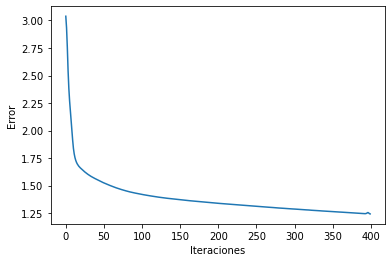

In [19]:
nn_Musica.train(trainset, ciclos=400)

# Precisión

## Precisión en el conjunto de entrenamiento.

In [20]:
nn_Musica.accurNet(trainset)

56.29702990514891

## Matriz de confusión para el conjunto de entrenamiento.

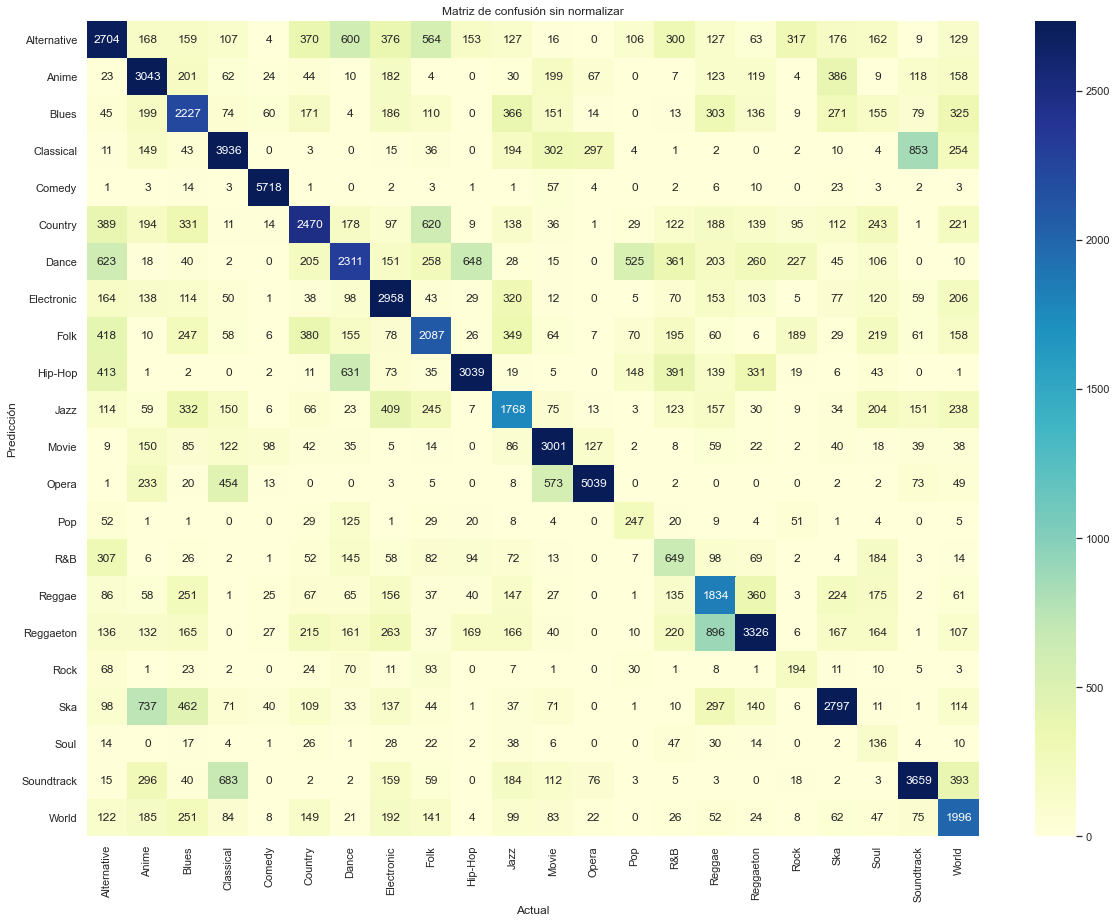

In [21]:
nn_Musica.confusion(trainset, 22)

## Precisión en el conjunto de prueba.

In [22]:
nn_Musica.accurNet(testset)

53.311416047265105

## Matriz de confusión para el conjunto de prueba.

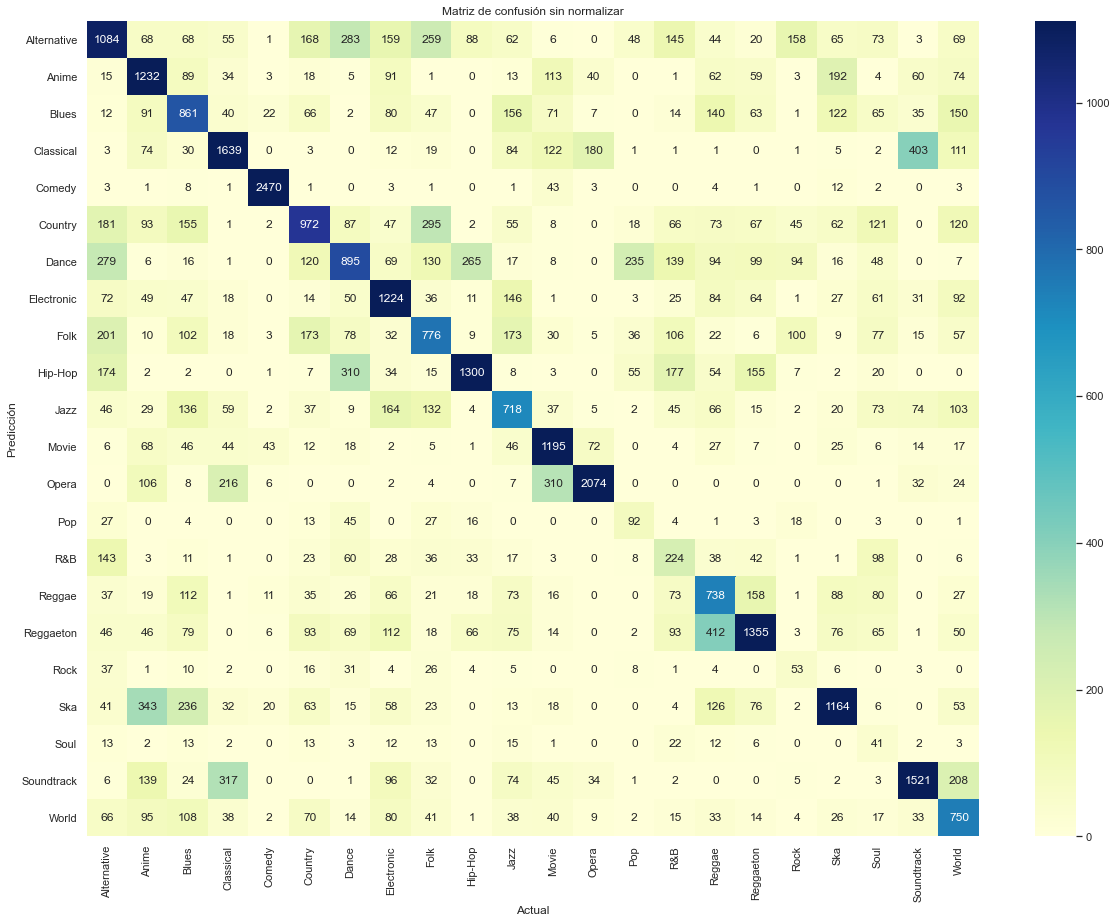

In [23]:
nn_Musica.confusion(testset, 22)

# Guardado del modelo.
Finalmente guardamos el modelo si se desean hacer pruebas posteriores y evitar el entrenamiento otra vez.

In [24]:
torch.save(nn_Musica.state_dict(), 'model/model')

# Cargar el modelo
Si se desea cargar el modelo basta con ejecutar las siguientes instrucciones.

In [25]:
nn_Musica_2 = Musica(29, 350, 22)
nn_Musica_2.load_state_dict(torch.load('model/model'))

<All keys matched successfully>

# Conclusiones sobre el proyecto

TODO: Sandy